# Project One Code 

## Econ 1680: MLTA and Econ

#### Name: Nadya Tan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Data Cleaning and Preparation

In [2]:
df_microdata = pd.read_csv('micro_world_139countries.csv', encoding='latin-1')

In [62]:
# select columns to keep 
selected = ['economycode', 'wgt','female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment', 'merchantpay_dig' ]
# new df 
df_selected = df_microdata[selected]

In [63]:
df_selected.shape

(143887, 32)

## One-hot Encoding 

In [64]:
# these variables need maps
# educ - change to 3 columns with 0-1 - if value is 4-5, put na in all 3 cols 
educ_dummies = pd.get_dummies(df_selected['educ'], prefix='educ').astype(int)
educ_dummies = educ_dummies.drop(columns=['educ_4', 'educ_5'])
# Fill NaN values for rows where educ was 4 or 5
educ_dummies.loc[df_selected['educ'].isin([4, 5]), :] = np.nan

# Convert inc_q to 5 columns
inc_q_dummies = pd.get_dummies(df_selected['inc_q'], prefix='inc_q').astype(int)
df_selected = pd.concat([df_selected, educ_dummies, inc_q_dummies], axis=1)

In [65]:
# Convert female to 0-1
df_selected['female'] = df_selected['female'].apply(lambda x: 1 if x == 1 else 0)

# Convert emp_in to 0-1
df_selected['emp_in'] = df_selected['emp_in'].apply(lambda x: 1 if x == 1 else 0)

# Convert urbanicity_f2f to 0-1
df_selected['urbanicity_f2f'] = df_selected['urbanicity_f2f'].apply(lambda x: 1 if x == 2 else 0)

In [66]:
# Convert these other financial variables to 0-1 and na for 3-4 
other_cols = [col for col in df_selected.columns if col in ['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a','mobileowner', 'internetaccess']]
for col in other_cols:
    df_selected[col] = df_selected[col].apply(lambda x: 1 if x == 1 else (0 if x == 2 else None))

In [67]:
def scale_value(value):
    # did not perform the act
    if value == 4:
        return 0
    # performed using cash
    elif value == 2:
        return 1
    # performed using account 
    elif value == 1:
        return 2
    else:
        return np.nan 

# Create new columns with scaled values
df_selected['receive_wages_scaled'] = df_selected['receive_wages'].apply(scale_value)
df_selected['receive_transfers_scaled'] = df_selected['receive_transfers'].apply(scale_value)
df_selected['receive_pension_scaled'] = df_selected['receive_pension'].apply(scale_value)
df_selected['receive_agriculture_scaled'] = df_selected['receive_agriculture'].apply(scale_value)
df_selected['pay_utilities_scaled'] = df_selected['pay_utilities'].apply(scale_value)

# Replace old column with 0-1 
def replace_value(value):
    if value in [1, 2, 3]:
        return 1
    elif value == 4:
        return 0
    else:
        return np.nan  # NaN for values 5
columns_to_process = ['receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities']
for column in columns_to_process:
    df_selected[column] = df_selected[column].apply(replace_value)

In [68]:
def scale_value_remittances(value):
    # did not perform the act
    if value == 5:
        return 0
    # performed using cash or OTC
    elif value in [2, 3]:
        return 1
    # performed using account 
    elif value == 1:
        return 2
    else:
        return np.nan 
df_selected['remittances_scaled'] = df_selected['remittances'].apply(scale_value)

def replace_value_remittances(value):
    if value in [1, 2, 3, 4]:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df_selected['remittances'] = df_selected['remittances'].apply(replace_value)

In [69]:
# economycode 
economycode_dummies = pd.get_dummies(df_selected['economycode']).astype(int)
df_selected = pd.concat([df_selected, economycode_dummies], axis=1)

In [70]:
df_selected.shape

(143887, 185)

In [71]:
# drop all NaNs - NOTE: SHOULD DO THIS AFTER SUMMARY STATS 
columns_to_process = ['economycode', 'wgt','female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob',  'fin13a', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment', 'merchantpay_dig','receive_wages_scaled', 'receive_transfers_scaled','receive_pension_scaled','receive_agriculture_scaled','pay_utilities_scaled', 'remittances_scaled'  ]

# Drop rows where any value in the specified columns is NaN
df_selected = df_selected.dropna(subset=columns_to_process)

In [72]:
df_selected.shape 

(11448, 185)

In [73]:
df_selected.to_csv('microdata_cleaned.csv')

## Summary Statistics 

In [80]:
# make a note that the fin variables are Na to preserve sample size - we can try tossing them in to see if they increase predictive power later on
df_selected[['female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment']].describe()

,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment
count,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.0,11448.000000,11448.0,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.0
mean,0.465671,32.895790,1.993623,3.759085,0.818833,0.478424,1.0,0.627446,1.0,0.787037,0.710255,0.449773,0.149371,0.046209,0.196716,0.542628,0.962002,0.959644,0.754630,1.0
std,0.498842,12.106833,0.640126,1.318487,0.385173,0.499556,0.0,0.483506,0.0,0.409420,0.453664,0.497493,0.356469,0.209946,0.397533,0.498201,0.191200,0.196802,0.430325,0.0
min,0.000000,15.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,24.000000,2.000000,3.000000,1.000000,0.000000,1.0,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
50%,0.000000,30.000000,2.000000,4.000000,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
75%,1.000000,40.000000,2.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
max,1.000000,99.000000,5.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [81]:
df_selected[['merchantpay_dig','receive_wages_scaled', 'receive_transfers_scaled','receive_pension_scaled','receive_agriculture_scaled','pay_utilities_scaled', 'remittances_scaled' ]].describe()

,merchantpay_dig,receive_wages_scaled,receive_transfers_scaled,receive_pension_scaled,receive_agriculture_scaled,pay_utilities_scaled,remittances_scaled
count,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000
mean,0.477201,0.800052,0.281359,0.089535,0.294637,0.957547,1.828005
std,0.499502,0.927687,0.682798,0.410105,0.635376,0.933041,0.467362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [82]:
df_selected[['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a']].describe()

,fin2,fin4,fin5,fin6,fin7,fin8,fin9,fin10,fin13a
count,11426.000000,4940.000000,6575.000000,6577.000000,6570.000000,1684.000000,6566.000000,6561.000000,11448.000000
mean,0.432960,0.652024,0.777490,0.781359,0.256925,0.846793,0.820743,0.814358,0.785465
std,0.495507,0.476376,0.415963,0.413356,0.436971,0.360294,0.383596,0.388847,0.410518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# educ, economycode and income 

# Comparing Regressions 


In [85]:
df_selected = df_selected.dropna()

In [86]:
df_selected.shape

(1486, 185)

In [87]:
# using only one-hot encoded variables first - no scales 
y=df_selected['fin13a']
X=df_selected.drop(columns=['fin13a', 'economycode','merchantpay_dig','receive_wages_scaled', 'receive_transfers_scaled','receive_pension_scaled','receive_agriculture_scaled','pay_utilities_scaled', 'remittances_scaled', 'educ', 'inc_q' ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680)

In [ ]:
# stratify? 

#### 19. Run an OLS regression on the training data. Produce the summary statistics using .summary() and paste them here:

Summary: 

In [88]:
# use weights for this! 
ols_result = sm.OLS(y_train, X_train).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 fin13a   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.171
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           1.51e-09
Time:                        12:47:06   Log-Likelihood:                -434.67
No. Observations:                1337   AIC:                             1071.
Df Residuals:                    1236   BIC:                             1596.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
wgt                    -0.0074    

#### 20. Run a LASSO regression on the training data and search over different alpha parameters in using alphas=np.linspace(1e-6, 1, num=50). Hint: reference the review session example for coding LASSO.
20a. What is the optimal alpha that you find?

Answer: 0.020409


In [89]:
# Define model
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso())

# Define parameter grid to search over using grid search
alphas = np.linspace(1e-6, 1, num=50)
params = {'lasso__alpha': alphas}

# Set up the grid search
gsLasso = GridSearchCV(lassoReg, params, n_jobs=-1, cv=10)

# Fit gs to data
gsLasso.fit(X, y)

# Check best alpha
print(gsLasso.best_params_['lasso__alpha'])
best_lasso_alpha = gsLasso.best_params_['lasso__alpha']

0.040817285714285716


20b. Insert a plot of alphas on the x axis and cv_errors on the y axis:


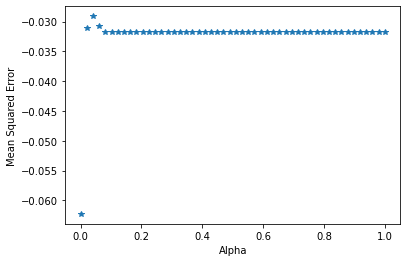

In [90]:
# Get the alpha values and corresponding mean test scores from the grid search results
alphas = np.linspace(1e-6, 1, num=50)
cv_errors = gsLasso.cv_results_['mean_test_score']

plt.plot(alphas, cv_errors,'*')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.show()

#### 21. Run a Ridge Regression on the training data and search over different alpha parameters in using alphas=np.linspace(1e-6, 1, num=50). Hint: reference the review session example for coding Ridge regressions.
21a. What is the optimal alpha that you find? 

Answer here: 0.20408242857142858

In [91]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=50)

# Construct vectors to store mean prediction errors and coefficients
cv_errs = []
coefs = []
MSE = 10
best_ridge_alpha = 0

# Loop for running ridge regression for different values of alpha
for a in alphas:
    
    # define pipeline object
    ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    # run Ridge regression
    ridgeReg.fit(X_train, y_train)
    # obtain predicted values of output
    y_pred = ridgeReg.predict(X_test)
    # compute mean squared error
    cv_errs.append(mean_squared_error(y_test, y_pred))
    # store coefficients
    coefs.append(ridgeReg['ridge'].coef_)
    
    # store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE: #np.mean((y_pred - y_test)**2)
        MSE = mean_squared_error(y_test, y_pred)
        best_ridge_alpha = a
        
print(best_ridge_alpha)
    
# Create dataframe for storing coefficients
coefs = pd.DataFrame(coefs, columns=X.columns)
coefs.set_index(alphas, inplace=True)

1.0


21b. Insert a plot of alphas on the x axis and cv_errros on the y axis:

Text(0, 0.5, 'Mean Squared Error')

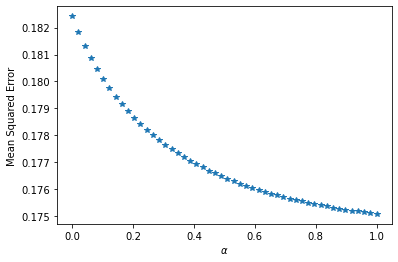

In [92]:
# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#### 22. Compare the regression coefficients from the three different approaches using:
``` python
coef_comp=pd.DataFrame({'var':X.columns, 'val_ols':olsReg.params.tolist(), 'val_lasso':lassoReg.coef_, 'var_ridge':ridgeReg.coef_})
```

22a. Insert the coef_comp table here:

```
```


In [93]:
alpha = best_lasso_alpha
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= alpha * np.sqrt(X_train.shape[0])))
lassoReg.fit(X_train, y_train)

alpha = best_ridge_alpha
ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= alpha * np.sqrt(X_train.shape[0])))
ridgeReg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridge', Ridge(alpha=36.565010597564445))])

In [94]:
coef_comp=pd.DataFrame({'var':X.columns, 'val_ols':ols_result.params.tolist(), 'val_lasso':lassoReg[-1].coef_, 'var_ridge':ridgeReg[-1].coef_})

In [95]:
print(coef_comp)


                var   val_ols  val_lasso  var_ridge
0               wgt -0.007420       -0.0  -0.004609
1            female -0.007554       -0.0  -0.003753
2               age -0.001186       -0.0  -0.013536
3            emp_in -0.010819       -0.0  -0.003244
4    urbanicity_f2f -0.037760        0.0  -0.015090
..              ...       ...        ...        ...
169             XKX  0.000000        0.0   0.000000
170             YEM  0.000000        0.0   0.000000
171             ZAF  0.074380        0.0   0.010293
172             ZMB  0.094894        0.0   0.007312
173             ZWE  0.183224        0.0   0.010123

[174 rows x 4 columns]


# V. CLASSIFICATION: LOGIT vs. NEURAL NETWORK

#### 23. Load the titanic3.csv file in as "df_titanic" from HW2_data.zip in the Canvas Assignment for HW2.


In [4]:
df_titanic = pd.read_csv('titanic3.csv')


#### 24. In Varian (2014), "Big Data: New Tricks for Econometrics", there is a discussion about wanting to allow for nonlinearity in age to affect the prediction of survival of Titanic passengers. This problem will compare estimating a logit with estimating neural network (multilayer perceptron). Explain the following lines of code and run them:

In [6]:
# Drop rows with missing values
df_titanic.dropna(subset=['survived','age', 'sex','pclass'],inplace=True) 
# Create a female dummy variable 
df_titanic['female']= np.where(df_titanic['sex']=='female',1,0) 
# Assign input and output variables, split data into train and test 
y= df_titanic['survived']
X= df_titanic[['age','pclass', 'female']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680) 

# Standardize the features
scaler=StandardScaler() 
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# train the multilayer perceptron classifier 
MLP = MLPClassifier(hidden_layer_sizes=(4,2),
  random_state=1680,
                    activation='logistic', solver='adam', 
                    max_iter =500,
                    verbose=True, learning_rate_init=0.01) 
MLP.fit(X_train,y_train)
print("MLP Training Accuracy:",accuracy_score(y_train,MLP.predict(X_train)))
print("MLP Testing Accuracy:",accuracy_score(y_test, MLP.predict(X_test)))

# train the logistic regression model 
logitmodel = LogisticRegression(solver='liblinear', random_state=1680).fit(X_train, y_train) 
print("Logit Training Accuracy:", accuracy_score(y_train,logitmodel.predict(X_train)))
print("Logit Testing Accuracy:", accuracy_score(y_test, logitmodel.predict(X_test)))


Iteration 1, loss = 0.71166718
Iteration 2, loss = 0.69564375
Iteration 3, loss = 0.68520857
Iteration 4, loss = 0.67802560
Iteration 5, loss = 0.67371194
Iteration 6, loss = 0.67103982
Iteration 7, loss = 0.66935104
Iteration 8, loss = 0.66743090
Iteration 9, loss = 0.66538807
Iteration 10, loss = 0.66293164
Iteration 11, loss = 0.66010487
Iteration 12, loss = 0.65671367
Iteration 13, loss = 0.65240347
Iteration 14, loss = 0.64770667
Iteration 15, loss = 0.64223625
Iteration 16, loss = 0.63618211
Iteration 17, loss = 0.62964568
Iteration 18, loss = 0.62252273
Iteration 19, loss = 0.61482248
Iteration 20, loss = 0.60667495
Iteration 21, loss = 0.59786557
Iteration 22, loss = 0.58870687
Iteration 23, loss = 0.57968533
Iteration 24, loss = 0.57040901
Iteration 25, loss = 0.56147817
Iteration 26, loss = 0.55234323
Iteration 27, loss = 0.54379160
Iteration 28, loss = 0.53601911
Iteration 29, loss = 0.52869627
Iteration 30, loss = 0.52233033
Iteration 31, loss = 0.51599733
Iteration 32, los

24a. Compare the accuracy scores in-sample and out-of-sample for the logit regression and for the neural network in 2-3 sentences. 

Answer here: The neural network performed better both in-sample (training accuracy) and out of sample (testing accuracy). However, the differences were not extremely noticable. 

24b. Is the difference between the accuracies what you would have expected? Spend 2-3 sentences discussing possible explanations for the differences. 

Answer here: These differences in accuracies are expected, since a linear model like logistic regression is likely unable to discover more nuances in the data, as the paper explains. However, it is interesting that the gap in accuracy scores is not as big as expected, showing that even if logistic regression may not uncover all hidden trends, it is still a relatively powerful predictor. 


24c. Print out the descriptive statistics for y_train and y_test

Paste output here: 

In [7]:
print("Descriptive Statistics for y_train:")
print(y_train.describe())

print("\nDescriptive Statistics for y_test:")
print(y_test.describe())

Descriptive Statistics for y_train:
count    836.000000
mean       0.399522
std        0.490093
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64

Descriptive Statistics for y_test:
count    210.000000
mean       0.442857
std        0.497911
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64


#### 25. Now rerun the previous code, but add stratify=y into the train_test_split command.

25a. How do the descriptive statistics for y_train and y_test change and how do the accuracy scores change?

Answer here: The accuracy score for logistic regression decreased for the test dataset, whereas the MLP network accuracy remained fairly constant. The mean and std for y_train and y_test is now more evenly distributed.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y) 

# Standardize the features
scaler=StandardScaler() 
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# train the multilayer perceptron classifier 
MLP = MLPClassifier(hidden_layer_sizes=(4,2),
  random_state=1680,
                    activation='logistic', solver='adam', 
                    max_iter =500,
                    verbose=True, learning_rate_init=0.01) 
MLP.fit(X_train,y_train)
print("MLP Training Accuracy:",accuracy_score(y_train,MLP.predict(X_train)))
print("MLP Testing Accuracy:",accuracy_score(y_test, MLP.predict(X_test)))

# train the logistic regression model 
logitmodel = LogisticRegression(solver='liblinear', random_state=1680).fit(X_train, y_train) 
print("Logit Training Accuracy:", accuracy_score(y_train,logitmodel.predict(X_train)))
print("Logit Testing Accuracy:", accuracy_score(y_test, logitmodel.predict(X_test)))

Iteration 1, loss = 0.70894753
Iteration 2, loss = 0.69741544
Iteration 3, loss = 0.68669943
Iteration 4, loss = 0.68101162
Iteration 5, loss = 0.67693919
Iteration 6, loss = 0.67398654
Iteration 7, loss = 0.67215091
Iteration 8, loss = 0.67096901
Iteration 9, loss = 0.66898181
Iteration 10, loss = 0.66659063
Iteration 11, loss = 0.66320451
Iteration 12, loss = 0.65927254
Iteration 13, loss = 0.65449687
Iteration 14, loss = 0.64898397
Iteration 15, loss = 0.64192832
Iteration 16, loss = 0.63462357
Iteration 17, loss = 0.62531451
Iteration 18, loss = 0.61571887
Iteration 19, loss = 0.60527922
Iteration 20, loss = 0.59445752
Iteration 21, loss = 0.58344477
Iteration 22, loss = 0.57183734
Iteration 23, loss = 0.56036779
Iteration 24, loss = 0.54944270
Iteration 25, loss = 0.53896643
Iteration 26, loss = 0.52987271
Iteration 27, loss = 0.52153519
Iteration 28, loss = 0.51403032
Iteration 29, loss = 0.50749977
Iteration 30, loss = 0.50196190
Iteration 31, loss = 0.49711786
Iteration 32, los

In [9]:
print("Descriptive Statistics for y_train:")
print(y_train.describe())

print("\nDescriptive Statistics for y_test:")
print(y_test.describe())

Descriptive Statistics for y_train:
count    836.000000
mean       0.407895
std        0.491738
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64

Descriptive Statistics for y_test:
count    210.000000
mean       0.409524
std        0.492921
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64


25b. What does “stratify” do and why would it change your results?

Answer here:  Stratify makes the y_train and y_test datasets more similar in distribution in terms of y, which ensures that the model is trained and evaluated on representative samples of each class. 

#### 26. Look at the other variables in df_titanic. What other variables besides age do you think would be important in predicting survival?

26a. List the variables you think of as important here and explain why you think they would improve prediction. Hint: you may need to transform variables into numerical representations/dummy variables.

Answer here: In addition to age, sex and class, I chose parch (number of parents and children) since I suspect having family on board may slow down evacuation. Furthermore, I chose embarked to capture geographical and cultural differences between individuals. 

26b. Run the logit regression with the variables that you listed and print the accuracy below. Did your accuracy improve?

Answer here: We can see that the training accuracy decreased slightly, but the testing accuarcy increased slightly. 

In [5]:
# Drop rows with missing values
df_titanic.dropna(subset=['survived','age', 'sex','pclass', 'parch', 'embarked'],inplace=True) 
# Create a female dummy variable 
df_titanic['female']= np.where(df_titanic['sex']=='female',1,0) 
# Create a has family dummy variable 
df_titanic['family']= np.where(df_titanic['parch']==0,0,1)
# Create dummies for each port of embarkation 
df_titanic['Cherbourg']= np.where(df_titanic['embarked']=='C',1,0)
df_titanic['Queenstown']= np.where(df_titanic['embarked']=='Q',1,0)
df_titanic['Southampton']= np.where(df_titanic['embarked']=='S',1,0)

# Assign input and output variables, split data into train and test 
y= df_titanic['survived']
X= df_titanic[['age','pclass', 'female', 'family', 'Cherbourg', 'Queenstown', 'Southampton']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y) 

# Standardize the features
scaler=StandardScaler() 
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# train the logistic regression model 
logitmodel = LogisticRegression(solver='liblinear', random_state=1680).fit(X_train, y_train) 
print("Logit Training Accuracy:", accuracy_score(y_train,logitmodel.predict(X_train)))
print("Logit Testing Accuracy:", accuracy_score(y_test, logitmodel.predict(X_test)))


Logit Training Accuracy: 0.7892215568862275
Logit Testing Accuracy: 0.7799043062200957
